In [31]:
#------Importing Libraries------#
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score, r2_score
import seaborn as sns

In [32]:
#---------Data loading and preprocessing---------#

# Load the data
data = pd.read_csv('proj-data.csv')

# Data preprocessing
# Remove trailing colons from column names
data.columns = data.columns.str.rstrip(':').str.strip()

# Replace non-numeric values with NaN
data.replace('?', np.nan, inplace=True)

# Handle binary columns
binary_columns = ['TSH measured', 'T3 measured', 'TT4 measured', 'T4U measured', 'FTI measured', 'TBG measured']
for col in binary_columns:
    data[col] = data[col].map({'f': 0, 't': 1})

# Convert appropriate columns to numeric
numeric_columns = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Check for negative values before imputation
print("Negative values before imputation in age:", (data['age'] < 0).sum())

# Handle missing values for numeric columns
imputer = SimpleImputer(strategy='mean')
data[numeric_columns] = imputer.fit_transform(data[numeric_columns])

# Check for negative values after imputation
print("Negative values after imputation in age:", (data['age'] < 0).sum())

# Encode categorical variables
label_encoders = {}
categorical_columns = ['sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication', 'sick', 'pregnant',
                       'thyroid surgery', 'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium', 
                       'goitre', 'tumor', 'hypopituitary', 'psych', 'diagnoses']
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column].astype(str))

# Preserve the record identification column
record_identification = data['[record identification]'].values

# Drop the record identification column from the main DataFrame
data.drop(columns=['[record identification]'], inplace=True)
data.drop(columns=['referral source'], inplace=True)

Negative values before imputation in age: 0
Negative values after imputation in age: 0


In [33]:
#--------Debugging--------#

# Ensure all data is numeric
#print(data.dtypes)

# Check for non-numeric data in the dataset
for col in data.columns:
    if data[col].dtype == 'object':
        print(f"Column {col} contains non-numeric values.")
        print(data[col].unique())

In [34]:
#----------Label Encoding and mapping----------#

# Define the mapping for new classes
diagnosis_mapping = {
    '-': 'healthy',
    'A': 'hyperthyroid conditions', 'B': 'hyperthyroid conditions', 'C': 'hyperthyroid conditions', 'D': 'hyperthyroid conditions',
    'E': 'hypothyroid conditions', 'F': 'hypothyroid conditions', 'G': 'hypothyroid conditions', 'H': 'hypothyroid conditions',
    'I': 'binding protein', 'J': 'binding protein',
    'K': 'general health',
    'L': 'replacement therapy', 'M': 'replacement therapy', 'N': 'replacement therapy',
    'R': 'discordant results'
}

# Add remaining classes to 'other'
original_diagnoses_labels = label_encoders['diagnoses'].classes_
for label in original_diagnoses_labels:
    if label not in diagnosis_mapping:
        diagnosis_mapping[label] = 'other'

# Map the diagnoses to new classes
data['diagnoses'] = data['diagnoses'].map(lambda x: diagnosis_mapping[label_encoders['diagnoses'].inverse_transform([x])[0]])

# Encode the new class labels
label_encoders['diagnoses'] = LabelEncoder()
data['diagnoses'] = label_encoders['diagnoses'].fit_transform(data['diagnoses'])

In [35]:
#--------Diagnose prediction model--------#

X_diagnosis = data.drop(['diagnoses'], axis=1)
y_diagnosis = data['diagnoses']

# Split data into training and testing sets for diagnosis prediction
X_train_diag, X_test_diag, y_train_diag, y_test_diag = train_test_split(X_diagnosis, y_diagnosis, test_size=0.2, random_state=42)

# Model training for diagnosis prediction
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_diag, y_train_diag)

# Model evaluation for diagnosis prediction
y_pred_diag = dt_classifier.predict(X_test_diag)

# Retrieve original class labels for diagnoses
new_diagnoses_labels = label_encoders['diagnoses'].classes_

# Print class labels and their corresponding diagnoses
for class_label, diagnosis in enumerate(new_diagnoses_labels):
    print(f"Class {class_label}: {diagnosis}")

print(classification_report(y_test_diag, y_pred_diag, target_names=new_diagnoses_labels))

# Create a DataFrame to display the results with record identification
predictions_df = pd.DataFrame({'Actual diagnose': y_test_diag, 'Predicted diagnose': y_pred_diag})
print(predictions_df)
print('MSE:', mean_squared_error(y_test_diag, y_pred_diag))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_diag, y_pred_diag))
print('RMSE:', rmse)

# Calculate accuracy
accuracy = accuracy_score(y_test_diag, y_pred_diag)
print('Accuracy score:', accuracy)

# Feature importance for diagnosis prediction
importances_diag = dt_classifier.feature_importances_
feature_importance_dt_diag = pd.DataFrame({'Feature': X_diagnosis.columns, 'Importance': importances_diag})
print(feature_importance_dt_diag.sort_values(by='Importance', ascending=False))

Class 0: binding protein
Class 1: discordant results
Class 2: general health
Class 3: healthy
Class 4: hyperthyroid conditions
Class 5: hypothyroid conditions
Class 6: other
Class 7: replacement therapy
                         precision    recall  f1-score   support

        binding protein       0.70      0.71      0.70        55
     discordant results       0.79      0.71      0.75        31
         general health       0.79      0.83      0.81        72
                healthy       0.97      0.96      0.97      1114
hyperthyroid conditions       0.75      0.72      0.73        25
 hypothyroid conditions       0.93      0.98      0.95        81
                  other       0.77      0.82      0.79        33
    replacement therapy       0.95      0.93      0.94        57

               accuracy                           0.93      1468
              macro avg       0.83      0.83      0.83      1468
           weighted avg       0.93      0.93      0.93      1468

      Actual d

(GBR)Negative X_age: 0
(RFR)Negative X_age: 0
(SVR)Negative X_age: 0
     Record Identification  Actual Age  Predicted Age
996            [841122082]        34.0      46.331496
736            [850912062]        58.0      53.055711
1244           [841127060]        41.0      47.124704
1181           [840823010]        28.0      60.530505
3305           [861024022]        69.0      65.125848
...                    ...         ...            ...
705            [850423010]        72.0      52.862519
6825           [861113052]        25.0      49.033146
6886           [861229030]        75.0      64.647162
4266           [860414048]        52.0      52.765923
57             [840903010]        69.0      37.283846

[1468 rows x 3 columns]
MSE: 317.06206082298036
RMSE: 17.806236571015795
Accuracy score: 0.10820292641861873
R2 score: 0.10820292641861873
                      Feature  Importance
18                         T3    0.368265
22                        T4U    0.147864
16               

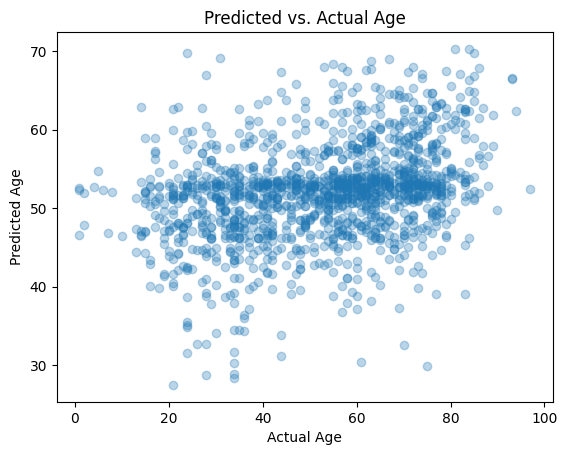

     Record Identification  Actual Age  Predicted Age
996            [841122082]        34.0      61.927933
736            [850912062]        58.0      50.480000
1244           [841127060]        41.0      35.180000
1181           [840823010]        28.0      66.340000
3305           [861024022]        69.0      60.640000
...                    ...         ...            ...
705            [850423010]        72.0      54.750000
6825           [861113052]        25.0      42.210000
6886           [861229030]        75.0      63.490000
4266           [860414048]        52.0      49.340000
57             [840903010]        69.0      33.830000

[1468 rows x 3 columns]
MSE: 332.9033507496775
RMSE: 18.245639225570518
Accuracy score: 0.06364629936045385
R2 score: 0.06364629936045385
                      Feature  Importance
16                        TSH    0.181324
22                        T4U    0.168507
20                        TT4    0.162771
18                         T3    0.149860
24 

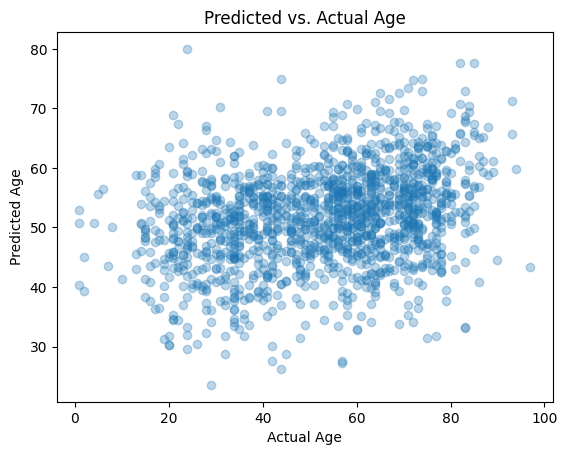

     Record Identification  Actual Age  Predicted Age
996            [841122082]        34.0      61.927933
736            [850912062]        58.0      50.480000
1244           [841127060]        41.0      35.180000
1181           [840823010]        28.0      66.340000
3305           [861024022]        69.0      60.640000
...                    ...         ...            ...
705            [850423010]        72.0      54.750000
6825           [861113052]        25.0      42.210000
6886           [861229030]        75.0      63.490000
4266           [860414048]        52.0      49.340000
57             [840903010]        69.0      33.830000

[1468 rows x 3 columns]
MSE: 320.17896200737033
RMSE: 17.89354526099762
Accuracy score: 0.09943605173274062
R2 score: 0.09943605173274062


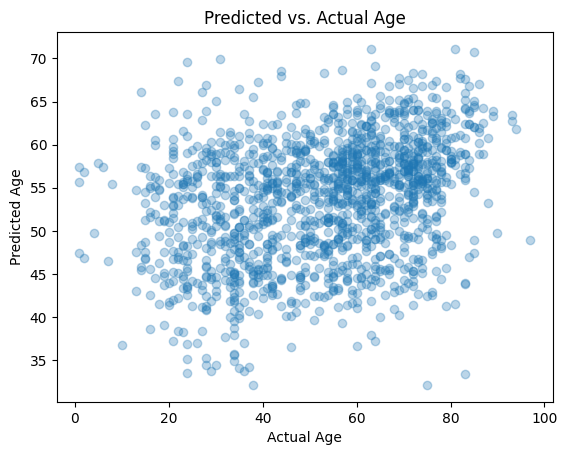

In [36]:
#---------Age prediction model---------#

X_age = data.drop(['age'], axis=1)
y_age = data['age']

#data_types = X_age.dtypes
#print('Data types: ', data_types)

# DEBUGGING
# Identify continuous and discrete features
#continuous_features = [col for col, dtype in data_types.items() if dtype == 'float64']
#discrete_features = [col for col, dtype in data_types.items() if dtype == 'int64']

#print("Continuous Features:", continuous_features)
#print("Discrete Features:", discrete_features)

# Removing outliers (example using IQR method)
Q1 = y_age.quantile(0.25)
Q3 = y_age.quantile(0.75)
IQR = Q3 - Q1
outlier_mask = (y_age >= (Q1 - 1.5 * IQR)) & (y_age <= (Q3 + 1.5 * IQR))

X_age_no_outliers = X_age[outlier_mask]
y_age_no_outliers = y_age[outlier_mask]
record_identification_no_outliers = record_identification[outlier_mask]

#X_age_discrete = X_age_no_outliers.select_dtypes(exclude=['float64'])

# Split data into training and testing sets for age prediction
X_train_age, X_test_age, y_train_age, y_test_age, record_train, record_test = train_test_split(X_age_no_outliers, y_age_no_outliers, record_identification_no_outliers, test_size=0.2, random_state=42)

# Apply feature scaling
scaler = StandardScaler()
X_train_age = scaler.fit_transform(X_train_age)
X_test_age = scaler.transform(X_test_age)

# Model training for age prediction
gbr_regressor = GradientBoostingRegressor()
gbr_regressor.fit(X_train_age, y_train_age)
print("(GBR)Negative X_age:", (gbr_regressor.predict(X_test_age) < 0).sum())

rfr_regressor = RandomForestRegressor()
rfr_regressor.fit(X_train_age, y_train_age)
print("(RFR)Negative X_age:", (rfr_regressor.predict(X_test_age) < 0).sum())

svr_regressor = SVR()
svr_regressor.fit(X_train_age, y_train_age)
print("(SVR)Negative X_age:", (svr_regressor.predict(X_test_age) < 0).sum())

# Age prediction evaluation
y_pred_age_gbr = gbr_regressor.predict(X_test_age)
y_pred_age_rfr = rfr_regressor.predict(X_test_age)
y_pred_age_svr = svr_regressor.predict(X_test_age)

#---------------------------------Gradient Boosting Regressor---------------------------------#
# Create a DataFrame to display the results with record identification
predictions_df = pd.DataFrame({'Record Identification': record_test, 'Actual Age': y_test_age, 'Predicted Age': y_pred_age_gbr})
print(predictions_df)
print('MSE:', mean_squared_error(y_test_age, y_pred_age_gbr))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_age, y_pred_age_gbr))
print('RMSE:', rmse)

# Calculate accuracy
accuracy_age = gbr_regressor.score(X_test_age, y_test_age)
print('Accuracy score:', accuracy_age)

# Calculate R2 score
r2 = r2_score(y_test_age, y_pred_age_gbr)
print('R2 score:', r2)

# Feature importance for age prediction
importances_age = gbr_regressor.feature_importances_
feature_importance_gbr_age = pd.DataFrame({'Feature': X_age_no_outliers.columns, 'Importance': importances_age})
print(feature_importance_gbr_age.sort_values(by='Importance', ascending=False))

# Plot predicted vs. actual ages
plt.scatter(y_test_age, y_pred_age_gbr, alpha=0.3)
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Predicted vs. Actual Age')
plt.show()

#---------------------------------Random Forest Regressor---------------------------------#
# Create a DataFrame to display the results with record identification
predictions_df2 = pd.DataFrame({'Record Identification': record_test, 'Actual Age': y_test_age, 'Predicted Age': y_pred_age_rfr})
print(predictions_df2)
print('MSE:', mean_squared_error(y_test_age, y_pred_age_rfr))

# Calculate RMSE
rmse2 = np.sqrt(mean_squared_error(y_test_age, y_pred_age_rfr))
print('RMSE:', rmse2)

# Calculate accuracy
accuracy_age2 = rfr_regressor.score(X_test_age, y_test_age)
print('Accuracy score:', accuracy_age2)

# Calculate R2 score
r2 = r2_score(y_test_age, y_pred_age_rfr)
print('R2 score:', r2)

# Feature importance for age prediction
importances_age2 = rfr_regressor.feature_importances_
feature_importance_rfr_age = pd.DataFrame({'Feature': X_age_no_outliers.columns, 'Importance': importances_age2})
print(feature_importance_rfr_age.sort_values(by='Importance', ascending=False))

# Plot predicted vs. actual ages
plt.scatter(y_test_age, y_pred_age_rfr, alpha=0.3)
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Predicted vs. Actual Age')
plt.show()

#---------------------------------SVR---------------------------------#
# Create a DataFrame to display the results with record identification
predictions_df3 = pd.DataFrame({'Record Identification': record_test, 'Actual Age': y_test_age, 'Predicted Age': y_pred_age_svr})
print(predictions_df2)
print('MSE:', mean_squared_error(y_test_age, y_pred_age_svr))

# Calculate RMSE
rmse3 = np.sqrt(mean_squared_error(y_test_age, y_pred_age_svr))
print('RMSE:', rmse3)

# Calculate accuracy
accuracy_age3 = svr_regressor.score(X_test_age, y_test_age)
print('Accuracy score:', accuracy_age3)

# Calculate R2 score
r2 = r2_score(y_test_age, y_pred_age_svr)
print('R2 score:', r2)

# Plot predicted vs. actual ages
plt.scatter(y_test_age, y_pred_age_svr, alpha=0.3)
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Predicted vs. Actual Age')
plt.show()

In [37]:
#---------Sex prediction model---------#

# Gender prediction model
X_gender = data.drop(['sex'], axis=1)
y_gender = data['sex']

# Split data into training and testing
X_train_gender, X_test_gender, y_train_gender, y_test_gender, record_train, record_test = train_test_split(X_gender, y_gender, record_identification, test_size=0.2, random_state=42)

# Model training
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_gender, y_train_gender)

y_pred_gender = rf_classifier.predict(X_test_gender)

predictions2_df = pd.DataFrame({'Record Identification': record_test, 'Actual gender': y_test_gender, 'Predicted sex': y_pred_gender})
print(predictions2_df)

# Feature importance for sex prediction
importances_gender = rf_classifier.feature_importances_
feature_importance_rf_gender = pd.DataFrame({'Feature': X_gender.columns, 'Importance': importances_gender})
print(feature_importance_rf_gender.sort_values(by='Importance', ascending=False))

print(classification_report(y_test_gender, y_pred_gender, target_names=label_encoders['sex'].classes_))

# Create a DataFrame to display the results with record identification
predictions_df = pd.DataFrame({'Record Identification': record_test, 'Actual gender': y_test_gender, 'Predicted gender': y_pred_gender})
print(predictions_df)
print('MSE:', mean_squared_error(y_test_gender, y_pred_gender))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_gender, y_pred_gender))
print('RMSE:', rmse)

# Calculate accuracy
accuracy_gender = accuracy_score(y_test_gender, y_pred_gender)
print('Accuracy score:', accuracy_gender)


     Record Identification  Actual gender  Predicted sex
996            [841122082]              0              0
736            [850912062]              1              0
1244           [841127060]              0              0
1181           [840823010]              0              0
3393           [861121057]              0              0
...                    ...            ...            ...
705            [850423010]              1              0
5219           [860210066]              0              0
5407           [861119045]              0              0
4267           [850801049]              0              0
57             [840903010]              0              1

[1468 rows x 3 columns]
                      Feature  Importance
0                         age    0.161265
22                        T4U    0.150866
20                        TT4    0.145415
16                        TSH    0.141446
24                        FTI    0.133971
18                         T3    0.1048

In [55]:
#---------Applying the models to the test sets---------#
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

#---------Reading the data---------#
# Read the first CSV file into a dataframe
test_data1 = pd.read_csv("mock-ups/proj-test-data.csv", sep=",")

# Read the second CSV file into a dataframe
test_data2 = pd.read_csv("mock-ups/proj-test-class.csv", sep=",")

# Ensure the length of both dataframes match
if len(test_data1) != len(test_data2):
    raise ValueError("The two files don't have the same number of rows")

# Merge the dataframes
test_data1['diagnoses'] = test_data2['diagnoses']

#---------Data Preprocessing---------#
# Clean column names
test_data1.columns = test_data1.columns.str.rstrip(':').str.strip()

# Replace '?' with NaN
test_data1.replace('?', np.nan, inplace=True)

# Convert binary columns from 'f'/'t' to 0/1
binary_columns = ['TSH measured', 'T3 measured', 'TT4 measured', 'T4U measured', 'FTI measured', 'TBG measured']
for col in binary_columns:
    test_data1[col] = test_data1[col].map({'f': 0, 't': 1})

# Convert numeric columns to float
numeric_columns = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']
for col in numeric_columns:
    test_data1[col] = pd.to_numeric(test_data1[col], errors='coerce')

# Impute missing values with the mean for numeric columns
imputer = SimpleImputer(strategy='mean')
test_data1[numeric_columns] = imputer.fit_transform(test_data1[numeric_columns])

# Encode categorical columns
label_encoders2 = {}
categorical_columns_final2 = ['sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication', 'sick', 'pregnant',
                             'thyroid surgery', 'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium', 
                             'goitre', 'tumor', 'hypopituitary', 'psych']
for column in categorical_columns_final2:
    label_encoders2[column] = LabelEncoder()
    test_data1[column] = label_encoders2[column].fit_transform(test_data1[column].astype(str))

# Drop unnecessary columns
test_data1.drop(columns=['[record identification]', 'referral source'], inplace=True)

# Encode the target column 'diagnoses'
label_encoders2['diagnoses'] = LabelEncoder()
test_data1['diagnoses'] = label_encoders2['diagnoses'].fit_transform(test_data1['diagnoses'].astype(str))

#---------Model Prediction---------#
# Assuming dt_classifier is already trained

X_final = test_data1.drop(columns=['diagnoses'], axis=1)
y_final = test_data1['diagnoses']

print(X_final)
print(y_final)

# Split data into training and testing sets for diagnosis prediction
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

# Model training for diagnosis prediction
dtc_classifier = DecisionTreeClassifier()
dtc_classifier.fit(X_train_final, y_train_final)

# Model evaluation for diagnosis prediction
y_pred_final = dtc_classifier.predict(X_test_final)

# Retrieve original class labels for diagnoses
new_diagnoses_labels2 = label_encoders2['diagnoses'].classes_

# Check unique classes
print("Unique classes in y_test_final:", np.unique(y_test_final))
print("Unique classes in y_pred_final:", np.unique(y_pred_final))
print("Target names:", new_diagnoses_labels2)

# Filter target names to match the unique classes in y_test_final
unique_classes = np.unique(np.concatenate((y_test_final, y_pred_final)))
filtered_target_names = [new_diagnoses_labels2[i] for i in unique_classes]

# Print class labels and their corresponding diagnoses
for class_label, diagnosis in enumerate(filtered_target_names):
    print(f"Class {class_label}: {diagnosis}")

print(classification_report(y_test_final, y_pred_final, target_names=filtered_target_names))

# Create a DataFrame to display the results with record identification
predictions_df2 = pd.DataFrame({'Actual diagnose': y_test_final, 'Predicted diagnose': y_pred_final})
print(predictions_df2)
print('MSE:', mean_squared_error(y_test_final, y_pred_final))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_final, y_pred_final))
print('RMSE:', rmse)

# Calculate accuracy
accuracy = accuracy_score(y_test_final, y_pred_final)
print('Accuracy score:', accuracy)

# Feature importance for diagnosis prediction
importances_final = dtc_classifier.feature_importances_
feature_importance_dtc_final = pd.DataFrame({'Feature': X_final.columns, 'Importance': importances_final})
print(feature_importance_dtc_final.sort_values(by='Importance', ascending=False))

     age  sex  on thyroxine  query on thyroxine  on antithyroid medication  \
0   29.0    0             0                   0                          0   
1   29.0    0             0                   0                          0   
2   36.0    0             0                   0                          0   
3   60.0    0             0                   0                          0   
4   77.0    0             0                   0                          0   
5   28.0    0             0                   0                          0   
6   28.0    0             0                   0                          0   
7   28.0    0             0                   0                          0   
8   54.0    0             0                   0                          0   
9   51.0    1             1                   0                          0   
10  51.0    0             0                   0                          0   
11  37.0    0             0                   0                 

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMet